# Cで整数を5バイトに押し込む簡単なお仕事

ビッグデータを処理するような場合、データの読み込みが律速になることが多いです。その場合、データのストレージ上のサイズが小さくなると読み込み時間が減り、全体の処理時間が半分になったりします。そんな時、整数が40bitで十分ならば、40bitで保持したいですね。というわけで、今まで[Go](https://www.soliton-cyber.com/blog/go-uint-40), [Rust](https://www.soliton-cyber.com/blog/rust-uint-40)とやってきましたが、処理効率を考えるとCと比較しないわけにはいきません。そこでCでも同様のことをやってみました。比較のため、clangとgccの両方を試します。

＊ 以下のコードは全てリトルエンディアンを前提にしております。ビッグエンディアン下の場合は意図しない結果になります。ご注意ください。

## 64bit整数の8バイト配列化

まずは愚直な方法

In [122]:
%%writefile main.c
#include <stdio.h>
#include <stdlib.h>
#include <stdint.h>
#include <time.h>

#define COUNT 10000000000
#define SIZE 100000

int main(int argc, char **argv)
{
    uint64_t vs[SIZE];
    for (int i = 0; i < SIZE; i += 1) {
        vs[i] = rand();
    }
    uint8_t buf[SIZE][8];

    // 計測開始
    clock_t start_clock, end_clock;
    start_clock = clock();
    for (size_t i = 0; i < COUNT/SIZE; i++) {
        for (size_t idx = 0; idx < SIZE; idx++) {
            uint64_t v = vs[idx];
            for (uint8_t j = 0; j < 8; j++) {
                buf[idx][j] = v >> (8 * j);
            }
        }
    }
    end_clock = clock();
    // 計測終了

    printf("%f sec\n", (double)(end_clock - start_clock) / CLOCKS_PER_SEC);
    for (int i = 0; i < 8; i++) printf("%d ", buf[0][i]);
    printf("\n");
    uint64_t total = 0;
    for (size_t i = 0; i < SIZE; i += 1) {
        for (size_t j = 0; j < 8; j += 1) {
            total += buf[i][j];
        }
    }
    printf("%lu\n", total); 
    return 0;
}

Overwriting main.c


In [117]:
!clang -Wall -Ofast main.c
!./a.out
!gcc -Wall -Ofast main.c
!./a.out

38.229933 sec
103 69 139 107 0 0 0 0 
44595596
33.922214 sec
103 69 139 107 0 0 0 0 
44595596


Goでは138秒、Rustでは8秒ですから、Goよりは速いですが、Rustより相当遅い。オプティマイザの性能の違いでしょうか。

それでは定石通り、内側のfor文を展開しましょう。

In [44]:
%%writefile main.c
#include <stdio.h>
#include <stdlib.h>
#include <stdint.h>
#include <time.h>

#define COUNT 10000000000
#define SIZE 100000

int main(int argc, char **argv)
{
    uint64_t vs[SIZE];
    for (int i = 0; i < SIZE; i += 1) {
        vs[i] = rand();
    }
    uint8_t buf[SIZE][8];

    // 計測開始
    clock_t start_clock, end_clock;
    start_clock = clock();
    for (size_t i = 0; i < COUNT/SIZE; i++) {
        for (size_t idx = 0; idx < SIZE; idx++) {
            uint64_t v = vs[idx];
            uint8_t *p = (uint8_t*)&buf[idx];
            p[0] = v;
            p[1] = v >> 8;
            p[2] = v >> 16;
            p[3] = v >> 24;
            p[4] = v >> 32;
            p[5] = v >> 40;
            p[6] = v >> 48;
            p[7] = v >> 56;
        }
    }
    end_clock = clock();
    // 計測終了

    printf("%f sec\n", (double)(end_clock - start_clock) / CLOCKS_PER_SEC);
    for (int i = 0; i < 8; i++) printf("%d ", buf[0][i]);
    printf("\n");
    uint64_t total = 0;
    for (size_t i = 0; i < SIZE; i += 1) {
        for (size_t j = 0; j < 8; j += 1) {
            total += buf[i][j];
        }
    }
    printf("%lu\n", total); 
    return 0;
}

Overwriting main.c


In [45]:
!clang -Wall -Ofast main.c
!./a.out
!gcc -Wall -Ofast main.c
!./a.out

33.967889 sec
103 69 139 107 0 0 0 0 
44595596
33.866115 sec
103 69 139 107 0 0 0 0 
44595596


Goはこれで40秒にまで改善されましたが、Cでは改善されませんでした。

さて、Goではポインターを使うことで8秒、Rustではライブラリを使って4秒まで短縮されました。Cではどうでしょうか。ポインターを使ってみます。

In [114]:
%%writefile main.c
#include <stdio.h>
#include <stdlib.h>
#include <stdint.h>
#include <time.h>

#define COUNT 10000000000
#define SIZE 100000

int main(int argc, char **argv)
{
    uint64_t vs[SIZE];
    for (int i = 0; i < SIZE; i += 1) {
        vs[i] = rand();
    }
    uint8_t buf[SIZE][8];

    // 計測開始
    clock_t start_clock, end_clock;
    start_clock = clock();
    for (size_t i = 0; i < COUNT/SIZE; i++) {
        for (size_t idx = 0; idx < SIZE; idx++) {
            *(uint64_t*)&buf[idx] = vs[idx];
        }
    }
    end_clock = clock();
    // 計測終了
 
    printf("%f sec\n", (double)(end_clock - start_clock) / CLOCKS_PER_SEC);
    for (int i = 0; i < 8; i++) printf("%d ", buf[0][i]);
    printf("\n");
    uint64_t total = 0;
    for (size_t i = 0; i < SIZE; i += 1) {
        for (size_t j = 0; j < 8; j += 1) {
            total += buf[i][j];
        }
    }
    printf("%lu\n", total);
    return 0;
}

Overwriting main.c


In [115]:
!clang -Wall -Ofast main.c
!./a.out
!gcc -Wall -Ofast main.c
!./a.out

3.651615 sec
103 69 139 107 0 0 0 0 
44595596
3.666405 sec
103 69 139 107 0 0 0 0 
44595596


Rustと同程度の速度です。ぎりぎりCの面目を保った感じです。

## 8バイト配列から64bit整数への変換

まずは素朴な実装

In [51]:
%%writefile main.c
#include <stdio.h>
#include <stdlib.h>
#include <stdint.h>
#include <time.h>

#define COUNT 10000000000
#define SIZE 100000

int main(int argc, char **argv)
{
    uint64_t vs[SIZE];
    uint8_t buf[SIZE][8];
    srand(0);
    for (int i = 0; i < SIZE; i += 1) {
        for (int j = 0; j < 8; j += 1) {
            buf[i][j] = (uint8_t)rand();
        }
    }

    // 計測開始
    clock_t start_clock, end_clock;
    start_clock = clock();
    for (size_t i = 0; i < COUNT/SIZE; i++) {
        for (size_t idx = 0; idx < SIZE; idx++) {
            uint8_t *b = (uint8_t*)&buf[idx];
            uint64_t v = 0;
            for (int j = 0; j < 8; j += 1) {
                v += ((uint64_t)b[j] << (8 * j));
            }
            vs[idx] = v;
        }
    }
    end_clock = clock();
    // 計測終了
 
    printf("%f sec\n", (double)(end_clock - start_clock) / CLOCKS_PER_SEC);
    printf("%lu\n", vs[0]);
    uint64_t total = 0;
    for (size_t i = 0; i < SIZE; i += 1) {
        total += vs[i];
    }
    printf("%lu\n", total);
    return 0;
}

Overwriting main.c


In [52]:
!clang -Wall -Ofast main.c
!./a.out
!gcc -Wall -Ofast main.c
!./a.out

23.052630 sec
17026702066521327207
3501406831367042067
34.285194 sec
17026702066521327207
3501406831367042067


Goで172秒、Rustで12秒ですから、微妙です。ここでclangとgccで違いが出ました。

あまり期待できませんが、念の為、内側のfor文を展開します。

In [53]:
%%writefile main.c
#include <stdio.h>
#include <stdlib.h>
#include <stdint.h>
#include <time.h>

#define COUNT 10000000000
#define SIZE 100000

int main(int argc, char **argv)
{
    uint64_t vs[SIZE];
    uint8_t buf[SIZE][8];
    srand(0);
    for (int i = 0; i < SIZE; i += 1) {
        for (int j = 0; j < 8; j += 1) {
            buf[i][j] = (uint8_t)rand();
        }
    }

    // 計測開始
    clock_t start_clock, end_clock;
    start_clock = clock();
    for (size_t i = 0; i < COUNT/SIZE; i++) {
        for (size_t idx = 0; idx < SIZE; idx++) {
            uint8_t *b = (uint8_t*)&buf[idx];
            uint64_t v = (uint64_t)b[0];
            v += (uint64_t)b[1] << 8;
            v += (uint64_t)b[2] << 16;
            v += (uint64_t)b[3] << 24;
            v += (uint64_t)b[4] << 32;
            v += (uint64_t)b[5] << 40;
            v += (uint64_t)b[6] << 48;
            v += (uint64_t)b[7] << 56;
            vs[idx] = v;
        }
    }
    end_clock = clock();
    // 計測終了
 
    printf("%f sec\n", (double)(end_clock - start_clock) / CLOCKS_PER_SEC);
    printf("%lu\n", vs[0]);
    uint64_t total = 0;
    for (size_t i = 0; i < SIZE; i += 1) {
        total += vs[i];
    }
    printf("%lu\n", total);
    return 0;
}

Overwriting main.c


In [54]:
!clang -Wall -Ofast main.c
!./a.out
!clang -Wall -Ofast main.c
!./a.out

23.004253 sec
17026702066521327207
3501406831367042067
22.974351 sec
17026702066521327207
3501406831367042067


やはり変わりません。ちなみにGoでは39秒、Rustでは19秒でした。Rustでは展開したほうが遅くなりました。と思ったら、gccの方が改善されています。gccではfor文の展開の最適化はなされないのでしょうか。

それでは本命のポインターによる実装です。

In [56]:
%%writefile main.c
#include <stdio.h>
#include <stdlib.h>
#include <stdint.h>
#include <time.h>

#define COUNT 10000000000
#define SIZE 100000

int main(int argc, char **argv)
{
    uint64_t vs[SIZE];
    uint8_t buf[SIZE][8];
    srand(0);
    for (int i = 0; i < SIZE; i += 1) {
        for (int j = 0; j < 8; j += 1) {
            buf[i][j] = (uint8_t)rand();
        }
    }

    // 計測開始
    clock_t start_clock, end_clock;
    start_clock = clock();
    for (size_t i = 0; i < COUNT/SIZE; i++) {
        for (size_t idx = 0; idx < SIZE; idx++) {
            vs[idx] = *(uint64_t*)&buf[idx];
        }
    }
    end_clock = clock();
    // 計測終了
 
    printf("%f sec\n", (double)(end_clock - start_clock) / CLOCKS_PER_SEC);
    printf("%lu\n", vs[0]);
    uint64_t total = 0;
    for (size_t i = 0; i < SIZE; i += 1) {
        total += vs[i];
    }
    printf("%lu\n", total);
    return 0;
}

Overwriting main.c


In [58]:
!clang -Wall -Ofast main.c
!./a.out
!gcc -Wall -Ofast main.c
!./a.out

3.775831 sec
17026702066521327207
3501406831367042067
3.784493 sec
17026702066521327207
3501406831367042067


さすがC。Goで13秒、Rustで6秒でしたから、相当速い。

ただ、同様にポインターを使用したRustが遅いのが気になります。Rustの実装は、
```
*(buf[idx].as_ptr() as *mut u64)
```
なのですが、as_ptr()の呼び出しに何らかのコストがかかっていると思われます。なにかもっといい方法があるかもしれません。


## 40bit整数の5バイト配列化

まずは素朴な実装

In [69]:
%%writefile main.c
#include <stdio.h>
#include <stdlib.h>
#include <stdint.h>
#include <time.h>

#define COUNT 10000000000
#define SIZE 100000

int main(int argc, char **argv)
{
    uint64_t vs[SIZE];
    for (int i = 0; i < SIZE; i += 1) {
        vs[i] = rand() & 0xFFFFFFFFFF;
    }
    uint8_t buf[SIZE][5];

    // 計測開始
    clock_t start_clock, end_clock;
    start_clock = clock();
    for (size_t i = 0; i < COUNT/SIZE; i++) {
        for (size_t idx = 0; idx < SIZE; idx++) {
            uint64_t v = vs[idx];
            uint8_t *b = (uint8_t*)buf[idx];
            for (uint8_t j = 0; j < 5; j++) {
                b[j] = v >> (8 * j);
            }
        }
    }
    end_clock = clock();
    // 計測終了
 
    printf("%f sec\n", (double)(end_clock - start_clock) / CLOCKS_PER_SEC);
    for (int i = 0; i < 5; i++) printf("%d ", buf[0][i]);
    printf("\n");
    uint64_t total = 0;
    for (size_t i = 0; i < SIZE; i += 1) {
        for (size_t j = 0; j < 5; j += 1) {
            total += buf[i][j];
        }
    }
    printf("%lu\n", total); 
    return 0;
}

Overwriting main.c


In [70]:
!clang -Wall -Ofast main.c
!./a.out
!gcc -Wall -Ofast main.c
!./a.out

21.516869 sec
103 69 139 107 0 
44595596
22.535876 sec
103 69 139 107 0 
44595596


８バイトの時は34秒でしたから、5バイトに減った分だけ順当に短縮されています。ちなみにGoでは90秒、Rustでは22秒でした。

次に内側のfor文の展開

In [63]:
%%writefile main.c
#include <stdio.h>
#include <stdlib.h>
#include <stdint.h>
#include <time.h>

#define COUNT 10000000000
#define SIZE 100000

int main(int argc, char **argv)
{
    uint64_t vs[SIZE];
    for (int i = 0; i < SIZE; i += 1) {
        vs[i] = rand() & 0xFFFFFFFFFF;
    }
    uint8_t buf[SIZE][5];

    // 計測開始
    clock_t start_clock, end_clock;
    start_clock = clock();
    for (size_t i = 0; i < COUNT/SIZE; i++) {
        for (size_t idx = 0; idx < SIZE; idx++) {
            uint64_t v = vs[idx];
            uint8_t *b = (uint8_t*)buf[idx];
            b[0] = v;
            b[1] = v << 8;
            b[2] = v << 16;
            b[3] = v << 24;
            b[4] = v << 32;
        }
    }
    end_clock = clock();
    // 計測終了
 
    printf("%f sec\n", (double)(end_clock - start_clock) / CLOCKS_PER_SEC);
    for (int i = 0; i < 5; i++) printf("%d ", buf[0][i]);
    printf("\n");
    uint64_t total = 0;
    for (size_t i = 0; i < SIZE; i += 1) {
        for (size_t j = 0; j < 5; j += 1) {
            total += buf[i][j];
        }
    }
    printf("%lu\n", total); 
    return 0;
}

Overwriting main.c


In [64]:
!clang -Wall -Ofast main.c
!./a.out
!gcc -Wall -Ofast main.c
!./a.out

10.166103 sec
103 0 0 0 0 
12778410
10.255147 sec
103 0 0 0 0 
12778410


こちらはclangもgccも速くなりました。最適化でどのような時にfor文の展開が行われるのか予測が難しい。

それではmemcpy()を使ってみましょう。

In [71]:
%%writefile main.c
#include <stdio.h>
#include <stdlib.h>
#include <stdint.h>
#include <time.h>
#include <string.h>

#define COUNT 10000000000
#define SIZE 100000

int main(int argc, char **argv)
{
    uint64_t vs[SIZE];
    for (int i = 0; i < SIZE; i += 1) {
        vs[i] = rand() & 0xFFFFFFFFFF;
    }
    uint8_t buf[SIZE][5];

    // 計測開始
    clock_t start_clock, end_clock;
    start_clock = clock();
    for (size_t i = 0; i < COUNT/SIZE; i++) {
        for (size_t idx = 0; idx < SIZE; idx++) {
            memcpy((void*)&buf[idx], (void*)&vs[idx], 5);
        }
    }
    end_clock = clock();
    // 計測終了
 
    printf("%f sec\n", (double)(end_clock - start_clock) / CLOCKS_PER_SEC);
    for (int i = 0; i < 5; i++) printf("%d ", buf[0][i]);
    printf("\n");
    uint64_t total = 0;
    for (size_t i = 0; i < SIZE; i += 1) {
        for (size_t j = 0; j < 5; j += 1) {
            total += buf[i][j];
        }
    }
    printf("%lu\n", total); 
    return 0;
}

Overwriting main.c


In [72]:
!clang -Wall -Ofast main.c
!./a.out
!gcc -Wall -Ofast main.c
!./a.out

10.927191 sec
103 69 139 107 0 
44595596
10.154510 sec
103 69 139 107 0 
44595596


for文を展開した時や、Rustで関数を利用した時と同程度になりました。Rustでも関数内部でmemcpy（）を使っているのかもしれません。
ちなみにGoの最速も同程度です。

次に、５バイトを4バイトと1バイトに分けて複製する方法を実装します。4バイトをuint32_tとして一命令で複製できるのが強みです。ただ、このコードはリトルエンディアンが前提なので、ご注意ください。

In [73]:
%%writefile main.c
#include <stdio.h>
#include <stdlib.h>
#include <stdint.h>
#include <time.h>
#include <string.h>

#define COUNT 10000000000
#define SIZE 100000

int main(int argc, char **argv)
{
    uint64_t vs[SIZE];
    for (int i = 0; i < SIZE; i += 1) {
        vs[i] = rand() & 0xFFFFFFFFFF;
    }
    uint8_t buf[SIZE][5];

    // 計測開始
    clock_t start_clock, end_clock;
    start_clock = clock();
    for (size_t i = 0; i < COUNT/SIZE; i++) {
        for (size_t idx = 0; idx < SIZE; idx++) {
            uint64_t v = vs[idx];
            uint8_t *b = (uint8_t*)buf[idx];
            *(uint32_t*)b = *(uint32_t*)&v;
            b[4] = ((uint8_t*)&v)[4];
            //b[4] = (uint8_t)(v >> 32);
        }
    }
    end_clock = clock();
    // 計測終了
 
    printf("%f sec\n", (double)(end_clock - start_clock) / CLOCKS_PER_SEC);
    for (int i = 0; i < 5; i++) printf("%d ", buf[0][i]);
    printf("\n");
    uint64_t total = 0;
    for (size_t i = 0; i < SIZE; i += 1) {
        for (size_t j = 0; j < 5; j += 1) {
            total += buf[i][j];
        }
    }
    printf("%lu\n", total); 
    return 0;
}

Overwriting main.c


In [74]:
!clang -Wall -Ofast main.c
!./a.out
!gcc -Wall -Ofast main.c
!./a.out

10.173033 sec
103 69 139 107 0 
44595596
main.c: In function ‘main’:
main.c:25:13: warning: dereferencing type-punned pointer will break strict-aliasing rules [-Wstrict-aliasing]
             *(uint32_t*)b = *(uint32_t*)&v;
             ^
10.200591 sec
103 69 139 107 0 
44595596


for文の展開や同様の処理をRustで実装した場合と同程度です。ただ、64bit整数の8バイト配列化が4秒程度ですから、cpuネイティブのビット幅と異なる整数の取り扱いにはそれなりのコストがかかることが分かります。それについにgccに警告を出されてしまいました。意図的にポイント先の整数をバラしているのですから、当然ですね。この辺りがリトルエンディアン限定である所以でもあります。処理速度的にもこれを採用する意味はないです。

## 5バイト配列から40bit整数への変換

素朴な方法

In [80]:
%%writefile main.c
#include <stdio.h>
#include <stdlib.h>
#include <stdint.h>
#include <time.h>

#define COUNT 10000000000
#define SIZE 100000

int main(int argc, char **argv)
{
    uint64_t vs[SIZE];
    uint8_t buf[SIZE][5];
    srand(0);
    for (int i = 0; i < SIZE; i += 1) {
        for (int j = 0; j < 5; j += 1) {
            buf[i][j] = (uint8_t)rand();
        }
    }

    // 計測開始
    clock_t start_clock, end_clock;
    start_clock = clock();
    for (size_t i = 0; i < COUNT/SIZE; i++) {
        for (size_t idx = 0; idx < SIZE; idx++) {
            uint8_t *b = (uint8_t*)&buf[idx];
            uint64_t v = b[0];
            for (size_t j = 1; j < 5; j++) {
                v += (uint64_t)(b[j]) << (8 * j);
            }
            vs[idx] = v;
        }
    }
    end_clock = clock();
    // 計測終了
 
    printf("%f sec\n", (double)(end_clock - start_clock) / CLOCKS_PER_SEC);
    printf("%lu\n", vs[0]);
    uint64_t total = 0;
    for (size_t i = 0; i < SIZE; i += 1) {
        total += vs[i];
    }
    printf("%lu\n", total);
    return 0;
}

Overwriting main.c


In [81]:
!clang -Wall -Ofast main.c
!./a.out
!gcc -Wall -Ofast main.c
!./a.out

19.252601 sec
349828662887
54993386919705396
17.163747 sec
349828662887
54993386919705396


内側のfor文の展開

In [82]:
%%writefile main.c
#include <stdio.h>
#include <stdlib.h>
#include <stdint.h>
#include <time.h>

#define COUNT 10000000000
#define SIZE 100000

int main(int argc, char **argv)
{
    uint64_t vs[SIZE];
    uint8_t buf[SIZE][5];
    srand(0);
    for (int i = 0; i < SIZE; i += 1) {
        for (int j = 0; j < 5; j += 1) {
            buf[i][j] = (uint8_t)rand();
        }
    }

    // 計測開始
    clock_t start_clock, end_clock;
    start_clock = clock();
    for (size_t i = 0; i < COUNT/SIZE; i++) {
        for (size_t idx = 0; idx < SIZE; idx++) {
            uint8_t *b = (uint8_t*)&buf[idx];
            uint64_t v = b[0];
            v += (uint64_t)(b[1]) << 8;
            v += (uint64_t)(b[2]) << 16;
            v += (uint64_t)(b[3]) << 24;
            v += (uint64_t)(b[4]) << 32;
            vs[idx] = v;
        }
    }
    end_clock = clock();
    // 計測終了
 
    printf("%f sec\n", (double)(end_clock - start_clock) / CLOCKS_PER_SEC);
    printf("%lu\n", vs[0]);
    uint64_t total = 0;
    for (size_t i = 0; i < SIZE; i += 1) {
        total += vs[i];
    }
    printf("%lu\n", total);
    return 0;
}

Overwriting main.c


In [83]:
!clang -Wall -Ofast main.c
!./a.out
!gcc -Wall -Ofast main.c
!./a.out

19.257227 sec
349828662887
54993386919705396
17.248058 sec
349828662887
54993386919705396


for文展開しても同じでした。8バイトの時が23秒でしたから、それなりに短縮されています。Goでは24秒、Rustでは10秒でした。

次に、uint64_tで取得してから0xFFFFFFFFFFでマスクすることで5バイト化する方法です。

In [84]:
%%writefile main.c
#include <stdio.h>
#include <stdlib.h>
#include <stdint.h>
#include <time.h>

#define COUNT 10000000000
#define SIZE 100000

int main(int argc, char **argv)
{
    uint64_t vs[SIZE];
    uint8_t buf[SIZE][5];
    srand(0);
    for (int i = 0; i < SIZE; i += 1) {
        for (int j = 0; j < 5; j += 1) {
            buf[i][j] = (uint8_t)rand();
        }
    }

    // 計測開始
    clock_t start_clock, end_clock;
    start_clock = clock();
    for (size_t i = 0; i < COUNT/SIZE; i++) {
        for (size_t idx = 0; idx < SIZE; idx++) {
            vs[idx] = ((*(uint64_t*)&buf[idx]) & 0xFFFFFFFFFF);
        }
    }
    end_clock = clock();
    // 計測終了
 
    printf("%f sec\n", (double)(end_clock - start_clock) / CLOCKS_PER_SEC);
    printf("%lu\n", vs[0]);
    uint64_t total = 0;
    for (size_t i = 0; i < SIZE; i += 1) {
        total += vs[i];
    }
    printf("%lu\n", total);
    return 0;
}

Overwriting main.c


In [85]:
!clang -Wall -Ofast main.c
!./a.out
!gcc -Wall -Ofast main.c
!./a.out

5.478499 sec
349828662887
54993386919705396
6.208831 sec
349828662887
54993386919705396


相当速い。ただ、64bitでは4秒でしたので、マスク処理にそれなりのコストがかかっています。ちなみに、Goの最速が14秒、Rustが7秒です。

マスクではなく、4バイトと1バイトに分ける方法を試してみます。

In [86]:
%%writefile main.c
#include <stdio.h>
#include <stdlib.h>
#include <stdint.h>
#include <time.h>

#define COUNT 10000000000
#define SIZE 100000

int main(int argc, char **argv)
{
    uint64_t vs[SIZE];
    uint8_t buf[SIZE][5];
    srand(0);
    for (int i = 0; i < SIZE; i += 1) {
        for (int j = 0; j < 5; j += 1) {
            buf[i][j] = (uint8_t)rand();
        }
    }

    clock_t start_clock, end_clock;
    start_clock = clock();
    for (size_t i = 0; i < COUNT/SIZE; i++) {
        for (size_t idx = 0; idx < SIZE; idx++) {
            uint8_t *b = buf[idx];
            vs[idx] = (*(uint32_t*)b) + (((uint64_t)b[4]) << 32);
        }
    }
    end_clock = clock();
 
    printf("%f sec\n", (double)(end_clock - start_clock) / CLOCKS_PER_SEC);
    printf("%lu\n", vs[0]);
    uint64_t total = 0;
    for (size_t i = 0; i < SIZE; i += 1) {
        total += vs[i];
    }
    printf("%lu\n", total);
    return 0;
}

Overwriting main.c


In [87]:
!clang -Wall -Ofast main.c
!./a.out
!gcc -Wall -Ofast main.c
!./a.out

6.204805 sec
349828662887
54993386919705396
7.772412 sec
349828662887
54993386919705396


遅くなりました。この処理ではマスクの方が有効です。

それとこのコードではgccが警告を出していません。uint8_tへのポインターをuint32_tのポインターに差し替えているので、当然警告が出ると思ったのですが、コンパイラーが検出できる限界を超えたようです。

## 40bit整数の配列の5Nバイト配列化

10万個の整数を5バイトずつのバイト配列にします。まずは素朴な実装。

In [88]:
%%writefile main.c
#include <stdio.h>
#include <stdlib.h>
#include <stdint.h>
#include <time.h>

#define COUNT 10000000000
#define SIZE 100000

int main(int argc, char **argv)
{
    uint64_t vs[SIZE];
    for (int i = 0; i < SIZE; i += 1) {
        vs[i] = rand() & 0xFFFFFFFFFF;
    }
    uint8_t buf[SIZE * 5];

    // 測定開始
    clock_t start_clock, end_clock;
    start_clock = clock();
    for (size_t i = 0; i < COUNT/SIZE; i++) {
        for (size_t idx = 0; idx< SIZE; idx++) {
            uint64_t v = vs[idx];
            size_t idx5 = idx * 5;
            uint8_t *b = (uint8_t*)(buf + idx5);
            for (uint8_t j = 0; j < 5; j++) {
                b[j] = v >> (8 * j);
            }
        }
    }
    end_clock = clock();
    // 測定終了
 
    printf("%f sec\n", (double)(end_clock - start_clock) / CLOCKS_PER_SEC);
    for (int i = 0; i < 5; i++) printf("%d ", buf[i]);
    printf("\n");
    uint64_t total = 0;
    for (size_t i = 0; i < SIZE * 5; i += 1) {
        total += buf[i];
    }
    printf("%lu\n", total); 
    return 0;
}

Overwriting main.c


In [89]:
!clang -Wall -Ofast main.c
!./a.out
!gcc -Wall -Ofast main.c
!./a.out

21.504752 sec
103 69 139 107 0 
44595596
22.461016 sec
103 69 139 107 0 
44595596


Goが104秒、Rustが21秒ですから、Rustと同等程度です。

次にfor文の展開

In [91]:
%%writefile main.c
#include <stdio.h>
#include <stdlib.h>
#include <stdint.h>
#include <time.h>

#define COUNT 10000000000
#define SIZE 100000

int main(int argc, char **argv)
{
    uint64_t vs[SIZE];
    for (int i = 0; i < SIZE; i += 1) {
        vs[i] = rand() & 0xFFFFFFFFFF;
    }
    uint8_t buf[SIZE * 5];

    // 測定開始
    clock_t start_clock, end_clock;
    start_clock = clock();
    for (size_t i = 0; i < COUNT/SIZE; i++) {
        for (size_t idx = 0; idx< SIZE; idx++) {
            uint64_t v = vs[idx];
            size_t idx5 = idx * 5;
            uint8_t *b = (uint8_t*)(buf + idx5);
            b[0] = v;
            b[1] = v >> 8;
            b[2] = v >> 16;
            b[3] = v >> 24;
            b[4] = v >> 32;
        }
    }
    end_clock = clock();
    // 測定終了
 
    printf("%f sec\n", (double)(end_clock - start_clock) / CLOCKS_PER_SEC);
    for (int i = 0; i < 5; i++) printf("%d ", buf[i]);
    printf("\n");
    uint64_t total = 0;
    for (size_t i = 0; i < SIZE * 5; i += 1) {
        total += buf[i];
    }
    printf("%lu\n", total); 
    return 0;
}

Overwriting main.c


In [92]:
!clang -Wall -Ofast main.c
!./a.out
!gcc -Wall -Ofast main.c
!./a.out

21.461715 sec
103 69 139 107 0 
44595596
22.414635 sec
103 69 139 107 0 
44595596


Goが16秒、Rustが21秒ですから、Rustと同程度ですが、Goより遅い。CやRustといえど工夫無くしてはGoに負けることがあるようです。

次に下図の戦略での実装。

<image width=500 src="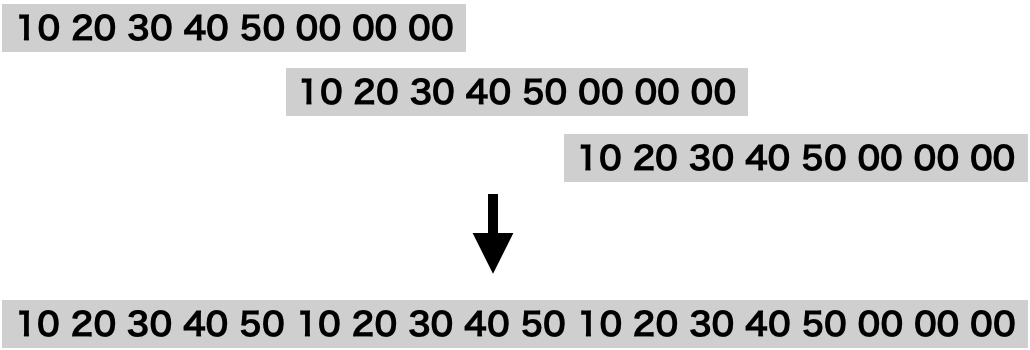">

In [93]:
%%writefile main.c
#include <stdio.h>
#include <stdlib.h>
#include <stdint.h>
#include <time.h>

#define COUNT 10000000000
#define SIZE 100000

int main(int argc, char **argv)
{
    uint64_t vs[SIZE];
    for (int i = 0; i < SIZE; i += 1) {
        vs[i] = rand() & 0xFFFFFFFFFF;
    }
    uint8_t buf[SIZE * 5 + 3];

    // 測定開始
    clock_t start_clock, end_clock;
    start_clock = clock();
    for (size_t i = 0; i < COUNT/SIZE; i++) {
        for (size_t idx = 0; idx < SIZE; idx++) {
            *(uint64_t*)(buf + idx * 5) = vs[idx];
        }
    }
    end_clock = clock();
    // 測定終了
 
    printf("%f sec\n", (double)(end_clock - start_clock) / CLOCKS_PER_SEC);
    for (int i = 0; i < 5; i++) printf("%d ", buf[i]);
    printf("\n");
    uint64_t total = 0;
    for (size_t i = 0; i < SIZE * 5; i += 1) {
        total += buf[i];
    }
    printf("%lu\n", total); 
    return 0;
}

Overwriting main.c


In [94]:
!clang -Wall -Ofast main.c
!./a.out
!gcc -Wall -Ofast main.c
!./a.out

6.795405 sec
103 69 139 107 0 
44595596
6.905677 sec
103 69 139 107 0 
44595596


Goが12秒、Rustが8秒ですので、Rustより少し速い程度です。

### 5Nバイト配列から40bit整数の配列への変換

5バイトずつのバイト配列から10万個の整数を読み出します。素朴な実装は以下になります。

In [95]:
%%writefile main.c
#include <stdio.h>
#include <stdlib.h>
#include <stdint.h>
#include <time.h>

#define COUNT 10000000000
#define SIZE 100000

int main(int argc, char **argv)
{
    uint64_t vs[SIZE];
    uint8_t buf[SIZE*5];
    srand(0);
    for (int i = 0; i < SIZE*5; i += 1) {
        buf[i] = (uint8_t)rand();
    }

    // 測定開始
    clock_t start_clock, end_clock;
    start_clock = clock();
    for (size_t i = 0; i < COUNT/SIZE; i++) {
        for (size_t idx = 0; idx < SIZE; idx += 1) {
            size_t idx5 = idx * 5;
            uint8_t *b = buf + idx5;
            uint64_t *v = vs + idx;
            *v = 0;
            for (size_t j = 0; j < 5; j++) {
                *v += (uint64_t)(b[j]) << (8 * j);
            }
        }
    }
    end_clock = clock();
    // 測定終了
 
    printf("%f sec\n", (double)(end_clock - start_clock) / CLOCKS_PER_SEC);
    printf("%lu\n", vs[0]);
    uint64_t total = 0;
    for (size_t i = 0; i < SIZE; i += 1) {
        total += vs[i];
    }
    printf("%lu\n", total);
    return 0;
}

Overwriting main.c


In [96]:
!clang -Wall -Ofast main.c
!./a.out
!gcc -Wall -Ofast main.c
!./a.out

15.320551 sec
349828662887
54993386919705396
17.172466 sec
349828662887
54993386919705396


内側のfor文の展開

In [97]:
%%writefile main.c
#include <stdio.h>
#include <stdlib.h>
#include <stdint.h>
#include <time.h>

#define COUNT 10000000000
#define SIZE 100000

int main(int argc, char **argv)
{
    uint64_t vs[SIZE];
    uint8_t buf[SIZE*5];
    srand(0);
    for (int i = 0; i < SIZE*5; i += 1) {
        buf[i] = (uint8_t)rand();
    }

    // 測定開始
    clock_t start_clock, end_clock;
    start_clock = clock();
    for (size_t i = 0; i < COUNT/SIZE; i++) {
        for (size_t idx = 0; idx < SIZE; idx += 1) {
            size_t idx5 = idx * 5;
            uint8_t *b = buf + idx5;
            uint64_t *v = vs + idx;
            *v = b[0];
            *v += (uint64_t)(b[1]) << 8;
            *v += (uint64_t)(b[2]) << 16;
            *v += (uint64_t)(b[3]) << 24;
            *v += (uint64_t)(b[4]) << 32;
        }
    }
    end_clock = clock();
    // 測定終了
 
    printf("%f sec\n", (double)(end_clock - start_clock) / CLOCKS_PER_SEC);
    printf("%lu\n", vs[0]);
    uint64_t total = 0;
    for (size_t i = 0; i < SIZE; i += 1) {
        total += vs[i];
    }
    printf("%lu\n", total);
    return 0;
}

Overwriting main.c


In [98]:
!clang -Wall -Ofast main.c
!./a.out
!gcc -Wall -Ofast main.c
!./a.out

15.340274 sec
349828662887
54993386919705396
17.157028 sec
349828662887
54993386919705396


Goが23秒、Rustが8秒ですので、間ぐらい。また、このコードでは、最適化によりfor文の展開が行われたようです。

0xFFFFFFFFFFによるマスクの方法。

In [155]:
%%writefile main.c
#include <stdio.h>
#include <stdlib.h>
#include <stdint.h>
#include <time.h>

#define COUNT 10000000000
#define SIZE 100000

int main(int argc, char **argv)
{
    uint64_t vs[SIZE];
    uint8_t buf[SIZE*5];
    srand(0);
    for (int i = 0; i < SIZE*5; i += 1) {
        buf[i] = (uint8_t)rand();
    }

    // 測定開始
    clock_t start_clock, end_clock;
    start_clock = clock();
    for (size_t i = 0; i < COUNT/SIZE; i++) {
        for (size_t idx = 0; idx < SIZE; idx += 1) {
            vs[idx] = *(uint64_t*)(buf + idx * 5) & 0xFFFFFFFFFF;
        }
    }
    end_clock = clock();
    // 測定終了
 
    printf("%f sec\n", (double)(end_clock - start_clock) / CLOCKS_PER_SEC);
    printf("%lu\n", vs[0]);
    uint64_t total = 0;
    for (size_t i = 0; i < SIZE; i += 1) {
        total += vs[i];
    }
    printf("%lu\n", total);
    return 0;
}

Overwriting main.c


In [156]:
!clang -Wall -Ofast main.c
!./a.out
!gcc -Wall -Ofast main.c
!./a.out

5.520705 sec
349828662887
54993386919705396
6.205896 sec
349828662887
54993386919705396


Goの最速が12秒、Rustが6.4秒ですから、Cでclangを使った場合が一番速くなりました。

## 結論

整数を5バイトに押し込む簡単なお仕事に関してはCとRustは同程度、Goは約半分の速度。

for文の展開はオプティマイザ任せにせずに自分でやっておいた方が無難。

strict-aliasing rulesの違反は取り扱い注意だが、そこまで踏み込まないとRustに負ける。（といってもRustでもunsafe使ってるけど)

## 追記

コメントにてコンパイラーの最適化を甘くみると痛い目にあうよというご指摘があったので、確かめてみます。

colabに最初から用意されているgccは最新版ではなかったので、まずはgcc-11をインストールします。

In [ ]:
!add-apt-repository 'deb http://mirrors.kernel.org/ubuntu hirsute main universe'
!apt update
!apt-get install gcc-11

次に一番最初の素朴な実装

In [140]:
%%writefile main.c
#include <stdio.h>
#include <stdlib.h>
#include <stdint.h>
#include <time.h>

#define COUNT 10000000000
#define SIZE 100000

int main(int argc, char **argv)
{
    uint64_t vs[SIZE];
    for (int i = 0; i < SIZE; i += 1) {
        vs[i] = rand();
    }
    uint8_t buf[SIZE][8];

    // 計測開始
    clock_t start_clock, end_clock;
    start_clock = clock();
    for (size_t i = 0; i < COUNT/SIZE; i++) {
        for (size_t idx = 0; idx < SIZE; idx++) {
            uint64_t v = vs[idx];
            for (uint8_t j = 0; j < 8; j++) {
                buf[idx][j] = v >> (8 * j);
            }
        }
    }
    end_clock = clock();
    // 計測終了

    printf("%f sec\n", (double)(end_clock - start_clock) / CLOCKS_PER_SEC);
    for (int i = 0; i < 8; i++) printf("%d ", buf[0][i]);
    printf("\n");
    uint64_t total = 0;
    for (size_t i = 0; i < SIZE; i += 1) {
        for (size_t j = 0; j < 8; j += 1) {
            total += buf[i][j];
        }
    }
    printf("%lu\n", total); 
    return 0;
}

Overwriting main.c


In [141]:
!gcc-11 -Wall -Ofast main.c
!./a.out

0.000102 sec
103 69 139 107 0 0 0 0 
44595596


確かに！　最後のルーブのbufしか使っていないのが最新のコンパイラーに見抜かれてしまったようです。

より慎重なのはこんなコードでしょうか。内側のループでvsの値が毎回異なるようにし、さらにvsの中身が乱数だということを悟られにくいように関数として切り出しました。そして全てのbufの値にアクセスして、使ってることをアピール。

In [145]:
%%writefile main.c
#include <stdio.h>
#include <stdlib.h>
#include <stdint.h>
#include <time.h>

#define COUNT 10000000000
#define SIZE 100000

clock_t measure(const uint64_t vs[], uint8_t buf[][8]) {
    clock_t start_clock = clock();
    for (size_t idx = 0; idx < SIZE; idx++) {
        uint64_t v = vs[idx];
        for (uint8_t j = 0; j < 8; j++) {
            buf[idx][j] = v >> (8 * j);
        }
    }
    return clock() - start_clock;
}

int main(int argc, char **argv)
{
    uint64_t vs[SIZE];
    uint8_t buf[SIZE][8];
    uint64_t total = 0;
    srand(0);

    clock_t total_clock = 0;
    for (size_t n = 0; n < COUNT/SIZE; n++) {
        for (int i = 0; i < SIZE*5; i += 1) {
            buf[i] = (uint8_t)rand();
        }
        total_clock += measure(vs, buf);
        for (size_t i = 0; i < SIZE; i += 1) {
            for (size_t j = 0; j < 8; j += 1) {
                total += buf[i][j];
            }
        }        
    }

    printf("%f sec\n", (double)total_clock / CLOCKS_PER_SEC);
    printf("%lu\n", total); 
    return 0;
}

Overwriting main.c


In [146]:
%%time
!gcc-11 -Wall -Ofast main.c
!./a.out

28.786703 sec
4459994566418
CPU times: user 1.25 s, sys: 169 ms, total: 1.42 s
Wall time: 2min 22s


それらしい計測値が得られました。

実務で採用する場合は、意図しない最適化の影響を避けるため、関数化して実データを流し込んで比較する必要がありそうです。

全てを関数化すると記事が長くなり過ぎてしまうので、最後のコードだけ書き換えてみました。

In [157]:
%%writefile main.c
#include <stdio.h>
#include <stdlib.h>
#include <stdint.h>
#include <time.h>

#define COUNT 10000000000
#define SIZE 100000

clock_t measure(uint64_t vs[], const uint8_t buf[]) {
    clock_t start_clock = clock();
    for (size_t idx = 0; idx < SIZE; idx += 1) {
        vs[idx] = *(uint64_t*)(buf + idx * 5) & 0xFFFFFFFFFF;
    }
    return clock() - start_clock;
}

int main(int argc, char **argv)
{
    uint64_t vs[SIZE];
    uint8_t buf[SIZE*5];
    uint64_t total = 0;
    srand(0);

    clock_t total_clock = 0;
    for (size_t n = 0; n < COUNT/SIZE; n++) {
        for (int i = 0; i < SIZE; i += 1) {
            vs[i] = rand();
        }
        total_clock += measure(vs, buf);
        for (size_t i = 0; i < SIZE; i += 1) {
            total += vs[i];
        }
    }

    printf("%f sec\n", (double)total_clock / CLOCKS_PER_SEC);
    printf("%lu\n", total);
    return 0;
}

Overwriting main.c


In [158]:
%%time
!gcc-11 -Wall -Ofast main.c
!./a.out

7.870699 sec
15006865253178248384
CPU times: user 1.11 s, sys: 142 ms, total: 1.25 s
Wall time: 2min 3s


細切れの時間計測を合計するので、誤差が増幅している可能性もあります。処理速度計測は一筋縄ではいきませんね。